<center><h1>UK Accidents
<h1>Predictive Model
<h3>Luca Mingardi, Alessandro Previero, Nova Zhang, Eugenio Zuccarelli

## 1. Libraries

In [ ]:
import interpretableai.iai as ai
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as sh
import sklearn.cluster as sc
import sklearn.ensemble as se
import sklearn.linear_model as lm
import sklearn.model_selection as ms
import sklearn.metrics as sm
import xgboost as xg
from IPython.display import display
from julia import Distributed


# Enable Parallel Processing
Distributed.addprocs(23)

# Jupyter Plots
%matplotlib inline

## 2. Parameters

In [16]:
predictive_features = ['Vehicle_Type','Towing_and_Articulation','Was_Vehicle_Left_Hand_Drive?', 
                       'Sex_of_Driver', 'Age_of_Driver', 'Engine_Capacity_(CC)', 'Propulsion_Code',
                       'Age_of_Vehicle', 'Driver_IMD_Decile', 'Driver_Home_Area_Type', 'Vehicle_IMD_Decile']

descriptive_features = ['Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude', 
                        'Latitude', 'Police_Force',
                        'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 
                        'Day_of_Week', 'Time', 'Local_Authority_(District)', 
                        'Local_Authority_(Highway)', '1st_Road_Class', '1st_Road_Number', 
                        'Road_Type', 'Speed_limit', 'Junction_Detail', 
                        'Junction_Control', '2nd_Road_Class', '2nd_Road_Number', 
                        'Pedestrian_Crossing-Human_Control', 'Carriageway_Hazards', 
                        'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions', 'Weather_Conditions', 
                        'Road_Surface_Conditions', 'Special_Conditions_at_Site', 'Urban_or_Rural_Area', 
                        'Did_Police_Officer_Attend_Scene_of_Accident', 'LSOA_of_Accident_Location',
                        'Vehicle_Manoeuvre','Vehicle_Location-Restricted_Lane', 'Junction_Location',
                        'Skidding_and_Overturning', 'Hit_Object_in_Carriageway','Vehicle_Leaving_Carriageway', 
                        'Hit_Object_off_Carriageway','1st_Point_of_Impact','Journey_Purpose_of_Driver',
                        'Pedestrian_Location', 'Pedestrian_Movement', 'Pedestrian_Road_Maintenance_Worker', 'Casualty_Type',
                        'Casualty_Home_Area_Type', 'Casualty_IMD_Decile', 'Casualty_Severity']

categorical_features = ['Vehicle_Type', 'Towing_and_Articulation', 'Sex_of_Driver', 
                        'Propulsion_Code', 'Driver_Home_Area_Type']
binary_features = ['Was_Vehicle_Left_Hand_Drive']

## 3. Data Loading

In [17]:
accidents = pd.read_csv('Data/dftRoadSafetyData_Accidents_2018.csv', low_memory=False)
casualties = pd.read_csv('Data/dftRoadSafetyData_Casualties_2018 11.28.09.csv', low_memory=False)
vehicles = pd.read_csv('Data/dftRoadSafetyData_Vehicles_2018 11.28.09.csv', low_memory=False)

In [18]:
casualties_vehicles = casualties.groupby(['Accident_Index', 'Vehicle_Reference'])['Casualty_Severity'].min().reset_index()
data = vehicles.merge(casualties_vehicles, how='left', on=['Accident_Index', 'Vehicle_Reference'])

columns = predictive_features
columns.append('Casualty_Severity')

data = data[columns]

## 4. Data Preprocessing

### Aggregate Unknown and Missing

In [5]:
data['Sex_of_Driver'] = data['Sex_of_Driver'].replace(3, -1)

### Remove NAs

In [6]:
data['Casualty_Severity'].fillna(value = 0, inplace = True)

In [7]:
data = data.replace(-1, np.nan)

### Variable Encoding

In [8]:
def severity(x):
    if x in (0.0, 3.0):
        return 0
    else:
        return 1

In [9]:
data['Casualty_Severity'] = data['Casualty_Severity'].apply(severity)

### One-Hot Encoding for Categorical Variables

In [10]:
for c in categorical_features:
    if c in data.columns:
        one_hot = pd.get_dummies(data[c], prefix=c)
        data = data.drop(c, axis=1)
        data = data.join(one_hot)

### Binary Variables Encoding

In [129]:
# Convert 1 and 2 to False and True
for b in binary_features:
    if b in data.columns:
        data[b] = data[b].map({1: 0, 2: 1})
        data[b] = data[b].astype(bool)

## 5. Split Train and Test Set

In [12]:
X = data[data.columns[~data.columns.isin(['Casualty_Severity'])]]
y = data['Casualty_Severity']
(train_X, train_y), (test_X, test_y) = ai.split_data('classification', X, y, seed=1)

## 6. Imputation

---

In this dataset, the missing values have been substituted wiith -1. Keeping such values throughout the dataset would introduce relationships across the data which are non-descriptive of the true nature of the data. Therefore, we proceed substituting -1 with NaN, and subsequently impute the dataset. To avoid biasing the imputation, we fit the imputation learner with the training set only, without the y variable, for then transforming training and test sets with such learner.

---

In [133]:
for c in train_X.columns:
    train_X[c].fillna(train_X[c].mean(), inplace=True)
    test_X[c].fillna(test_X[c].mean(), inplace=True)

In [10]:
lnr = ai.ImputationLearner(method='opt_knn', random_seed=1, cluster=True)

lnr.fit(train_X)

train_X = lnr.transform(train_X)
test_X = lnr.transform(test_X)

### Logistic Regression

In [135]:
# Logistic Regression Model
model = lm.LogisticRegression()

# Hyperparameters
params = {
 'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
 'penalty': ['l1', 'l2'],
 'max_iter': [1000],
 'class_weight': ['balanced']
}

# Grid Search
clf = ms.GridSearchCV(model, params)

# Model Fit
model = clf.fit(train_X, train_y)

### Logistic Regression Performance

In [136]:
predictions_train = model.predict(train_X)
predictions_test = model.predict(test_X)
print('in-sample', sm.roc_auc_score(train_y, predictions_train))
print('out-of-sample', sm.roc_auc_score(test_y, predictions_test))

in-sample 0.639264127666692
out-of-sample 0.641060605487368


### Random Forests

In [139]:
# Logistic Regression Model
model = se.RandomForestClassifier()

# Hyperparameters
params = {
 'max_depth': [10],
 'n_estimators': [100],
 'class_weight': [{0: 1, 1: 4}]
}

# Grid Search
clf = ms.GridSearchCV(model, params)

# Model Fit
model = clf.fit(train_X, train_y)

In [140]:
predictions_train = model.predict(train_X)
predictions_test = model.predict(test_X)
print('in-sample', sm.roc_auc_score(train_y, predictions_train))
print('out-of-sample', sm.roc_auc_score(test_y, predictions_test))

in-sample 0.6227263886992135
out-of-sample 0.6184687816717024


### Gradient Boosting

In [15]:
# Gradient Boosting Model
model = xg.XGBClassifier()

# Hyperparameters
params = {
        'nthread': [4],
        'eta': [0.001],
        'max_depth': [10],
        'n_estimators': [100],
        'scale_pos_weight': [14]
        }

# Grid Search
grid = ms.GridSearchCV(model, params)

# Model Fit
model = grid.fit(train_X, train_y)

/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if d

In [16]:
predictions_train = model.predict(train_X)
predictions_test = model.predict(test_X)
print('in-sample', sm.roc_auc_score(train_y, predictions_train))
print('out-of-sample', sm.roc_auc_score(test_y, predictions_test))

/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


in-sample 0.6107962123050377
out-of-sample 0.592000275840628


/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Optimal Classification Trees

In [14]:
# Model
grid = ai.GridSearch(
    ai.OptimalTreeClassifier(
        random_seed=1,
    ),
    max_depth=7,
    treat_unknown_level_missing=True,
    missingdatamode='separate_class',
    criterion='gini'
)

# Train the Model
grid.fit(train_X, train_y)

KeyboardInterrupt: 

In [ ]:
print(grid.score(train_X, train_y, criterion='auc'))
print(grid.score(test_X, test_y, criterion='auc'))

## Clustering

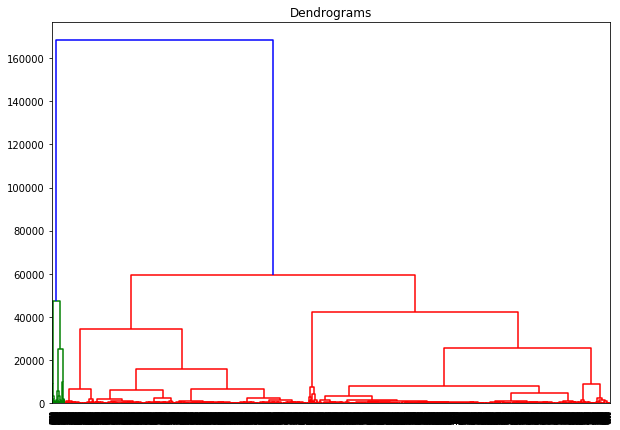

In [31]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")
dend = sh.dendrogram(sh.linkage(train_X.sample(10000), method='ward'))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Text(0,0.5,'Intertia, SSD')

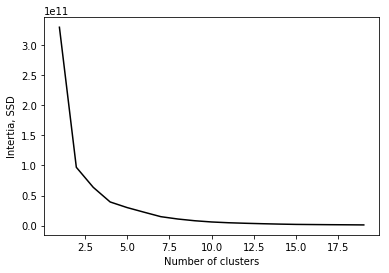

In [30]:
SSEs = []
for k in range(1, 20):
    print(k)
    kmeans = sc.KMeans(n_clusters=k, random_state=0, n_init = 25).fit(train_X)
    SSEs.append(kmeans.inertia_)
plt.plot(range(1,20), SSEs, 'k')
plt.xlabel("Number of clusters")
plt.ylabel("Intertia, SSD")

In [34]:
km = sc.KMeans(n_clusters=4, random_state=0, n_init = 25)
km.fit(train_X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=25, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [36]:
labeled_data = train_X
labeled_data['label'] = km.labels_

In [38]:
for k in range(4):
    display(labeled_data[labeled_data['label']==k].describe())

,Vehicle_Type,Towing_and_Articulation,Was_Vehicle_Left_Hand_Drive?,Sex_of_Driver,Age_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Vehicle_IMD_Decile,label
count,104322.000000,104322.000000,104322.000000,104322.000000,104322.000000,104322.000000,104322.000000,104322.000000,104322.000000,104322.000000,104322.000000,104322.0
mean,10.594526,0.030151,1.007749,1.475216,41.403750,1916.227692,1.810392,8.199777,5.153002,1.318882,5.153002,0.0
std,12.777910,0.324970,0.085966,0.704266,14.291687,312.441960,1.076012,4.084233,2.375224,0.591070,2.375224,0.0
min,1.000000,0.000000,1.000000,1.000000,3.000000,1489.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0
25%,9.000000,0.000000,1.000000,1.000000,31.000000,1796.000000,1.610931,6.000000,4.000000,1.000000,4.000000,0.0
50%,9.000000,0.000000,1.000000,1.000000,40.877359,1873.814037,1.610931,8.122614,5.144117,1.000000,5.144117,0.0
75%,9.000000,0.000000,1.000000,2.000000,50.000000,1995.000000,2.000000,10.000000,6.000000,1.316849,6.000000,0.0
max,98.000000,5.000000,2.000000,3.000000,101.000000,3700.000000,12.000000,84.000000,10.000000,3.000000,10.000000,0.0


,Vehicle_Type,Towing_and_Articulation,Was_Vehicle_Left_Hand_Drive?,Sex_of_Driver,Age_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Vehicle_IMD_Decile,label
count,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.0
mean,19.413793,0.527716,1.004976,1.088670,45.357164,11567.442902,2.031348,5.986648,4.744958,1.366033,4.744958,1.0
std,9.161183,0.829063,0.070028,0.372944,12.003615,2609.698270,0.310946,3.984082,2.316104,0.663681,2.316104,0.0
min,2.000000,0.000000,1.000000,1.000000,17.000000,8709.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
25%,19.000000,0.000000,1.000000,1.000000,36.000000,10308.000000,2.000000,3.000000,3.000000,1.000000,3.000000,1.0
50%,21.000000,0.000000,1.000000,1.000000,46.000000,12130.000000,2.000000,5.000000,5.144117,1.000000,5.144117,1.0
75%,21.000000,1.000000,1.000000,1.000000,54.000000,12777.000000,2.000000,8.122614,6.000000,1.316849,6.000000,1.0
max,90.000000,5.000000,2.000000,3.000000,78.000000,99999.000000,5.000000,33.000000,10.000000,3.000000,10.000000,1.0


,Vehicle_Type,Towing_and_Articulation,Was_Vehicle_Left_Hand_Drive?,Sex_of_Driver,Age_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Vehicle_IMD_Decile,label
count,3693.000000,3693.000000,3693.000000,3693.000000,3693.000000,3693.000000,3693.000000,3693.000000,3693.000000,3693.000000,3693.000000,3693.0
mean,14.340374,0.121645,1.010171,1.174113,45.235742,5495.047116,1.882210,7.301924,4.673770,1.291174,4.673770,2.0
std,11.950616,0.665549,0.099595,0.494018,12.272001,1222.414505,0.479188,5.373224,2.351987,0.609333,2.351987,0.0
min,8.000000,0.000000,1.000000,1.000000,16.000000,3721.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.0
25%,11.000000,0.000000,1.000000,1.000000,37.000000,4462.000000,2.000000,3.000000,3.000000,1.000000,3.000000,2.0
50%,11.000000,0.000000,1.000000,1.000000,45.000000,5132.000000,2.000000,6.000000,5.000000,1.000000,5.000000,2.0
75%,11.000000,0.000000,1.000000,1.000000,54.000000,6700.000000,2.000000,10.000000,6.000000,1.316849,6.000000,2.0
max,90.000000,5.000000,2.000000,3.000000,98.000000,8500.000000,8.000000,65.000000,10.000000,3.000000,10.000000,2.0


,Vehicle_Type,Towing_and_Articulation,Was_Vehicle_Left_Hand_Drive?,Sex_of_Driver,Age_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Vehicle_IMD_Decile,label
count,48239.000000,48239.000000,48239.000000,48239.000000,48239.000000,48239.000000,48239.000000,48239.000000,48239.000000,48239.000000,48239.000000,48239.0
mean,7.948880,0.007976,1.003635,1.473683,39.197948,1056.140281,1.139348,8.117443,5.179385,1.312139,5.179385,3.0
std,3.041015,0.187909,0.058736,0.576110,17.654945,415.505794,0.574614,5.473083,2.535820,0.620858,2.535820,0.0
min,2.000000,0.000000,1.000000,1.000000,12.000000,48.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0
25%,9.000000,0.000000,1.000000,1.000000,24.000000,998.000000,1.000000,4.000000,3.000000,1.000000,3.000000,3.0
50%,9.000000,0.000000,1.000000,1.000000,36.000000,1229.000000,1.000000,8.000000,5.144117,1.000000,5.144117,3.0
75%,9.000000,0.000000,1.000000,2.000000,50.000000,1364.000000,1.000000,12.000000,7.000000,1.316849,7.000000,3.0
max,90.000000,5.000000,2.000000,3.000000,99.000000,1477.000000,8.000000,81.000000,10.000000,3.000000,10.000000,3.0


In [10]:
data

,Vehicle_Type,Towing_and_Articulation,Was_Vehicle_Left_Hand_Drive?,Sex_of_Driver,Age_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Vehicle_IMD_Decile,Casualty_Severity
0,9.0,0.0,1.0,1.0,32.0,1995.0,2.0,5.0,8.0,1.0,8.0,0
1,8.0,0.0,1.0,1.0,48.0,1798.0,8.0,6.0,1.0,1.0,1.0,0
2,9.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,8.0,0.0,1.0,1.0,40.0,1797.0,8.0,6.0,3.0,1.0,3.0,0
4,9.0,0.0,1.0,1.0,21.0,NaN,NaN,NaN,5.0,1.0,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
226404,9.0,0.0,1.0,1.0,67.0,998.0,1.0,4.0,NaN,3.0,NaN,0
226405,9.0,0.0,1.0,1.0,24.0,3000.0,2.0,21.0,NaN,3.0,NaN,0
226406,9.0,0.0,1.0,NaN,NaN,2400.0,2.0,5.0,NaN,NaN,NaN,0
226407,2.0,0.0,1.0,1.0,60.0,49.0,1.0,10.0,NaN,3.0,NaN,1


In [13]:
train_X

,Vehicle_Type,Towing_and_Articulation,Was_Vehicle_Left_Hand_Drive?,Sex_of_Driver,Age_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Vehicle_IMD_Decile
0,9.0,0.0,1.0,1.0,32.0,1995.0,2.0,5.0,8.0,1.0,8.0
1,9.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8.0,0.0,1.0,1.0,40.0,1797.0,8.0,6.0,3.0,1.0,3.0
3,9.0,0.0,1.0,1.0,27.0,1200.0,1.0,1.0,7.0,1.0,7.0
4,19.0,0.0,1.0,1.0,30.0,NaN,NaN,NaN,3.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
158482,9.0,0.0,1.0,1.0,25.0,1900.0,2.0,14.0,NaN,1.0,NaN
158483,9.0,0.0,1.0,1.0,55.0,1968.0,2.0,1.0,NaN,3.0,NaN
158484,9.0,0.0,1.0,NaN,NaN,2400.0,2.0,5.0,NaN,NaN,NaN
158485,2.0,0.0,1.0,1.0,60.0,49.0,1.0,10.0,NaN,3.0,NaN


In [ ]:
# Logistic Regression
# 
# params = {
#  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
#  'penalty': ['l1', 'l2'],
#  'max_iter': [1000],
#  'class_weight': ['balanced']
# }
# 
# in-sample 0.6163394626580004
# out-of-sample 0.6155783655156614


# RF
# 
# params = {
#  'max_depth': [10],
#  'n_estimators': [100],
#  'class_weight': [{0: 1, 1: 4}]
# }
# 
# in-sample 0.6290399386267982
# out-of-sample 0.6238579399861871

# XGB
# 
# params = {
#         'nthread': [8],
#         'eta': [0.001],
#         'max_depth': [6],
#         'n_estimators': [100],
#         'scale_pos_weight': [14]
#         }

# in-sample 0.6116476003349836
# out-of-sample 0.5920113193128831

logistic with one-hot and mean imputation
in-sample 0.639264127666692
out-of-sample 0.641060605487368

oct with nan instead of -1
>>> print(grid.score(train_X, train_y, criterion='auc'))
0.6929286415088861
>>> print(grid.score(test_X, test_y, criterion='auc'))
0.6853128666653053


depth 10
>>> print(grid.score(train_X, train_y, criterion='auc'))
0.7095518095530852
>>> print(grid.score(test_X, test_y, criterion='auc'))
0.6950604509392206